## Imports

In [3]:
import json
import sys
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

sys.path.append('..')
from const import *

## Support Functions

In [4]:
def compute_bins2(arr, arr2, breaks):
    densities = []
    bins = []
    for i in range(len(breaks)):
        temp = []
        for j, value in enumerate(arr):
            if i == 0:
                if value <= breaks[i]:
                    temp.append(arr2[j])
            else:
                if (value <= breaks[i]) & (value > breaks[i-1]):
                    temp.append(arr2[j])
        if temp:
            densities.append(len(temp)/len(repo_names))
            bins.append(temp)
    return breaks, bins, densities

## Overall Statistic

In [5]:
# load pull request data that contain vulnerabilities
pr_vuln = pd.read_csv(CSV_DATA['pr_vulnerabilities'], index_col=False)
pr_vuln['severities'] = pr_vuln['severities'].apply(literal_eval)

rejected_prs = sum(pr_vuln['state'] == 'CLOSED')
merged_prs = sum(pr_vuln['state'] == 'MERGED')

print('Pull request statistics')
print('total: {}'.format(len(pr_vuln.index)))
print('')
print('open: '+str(sum(pr_vuln['state'] == 'OPEN'))+' ('+str((sum(pr_vuln['state'] == 'OPEN')/len(pr_vuln))*100)+')')
print('closed: '+str(sum(pr_vuln['state'] != 'OPEN'))+' ('+str((sum(pr_vuln['state'] != 'OPEN')/len(pr_vuln))*100)+')')
print('')
print('rejected: '+str(rejected_prs)+' ('+str(rejected_prs/sum(pr_vuln['state'] != 'OPEN')*100)+')')
print('merged: '+str(merged_prs)+' ('+str(merged_prs/sum(pr_vuln['state'] != 'OPEN')*100)+')')


Pull request statistics
total: 4416

open: 221 (5.004528985507246)
closed: 4195 (94.99547101449275)

rejected: 1804 (43.00357568533969)
merged: 2391 (56.99642431466031)


## Merge Rate Analysis

In [6]:
# load the names (GitHub slugs) of the selected repositories
repo_names = pd.read_csv(CSV_DATA['dependabot_filtered_repos'], index_col=False)['repository'].tolist()

In [7]:
projects_with_closed = []
merged = []
total = []
ratio = []
for repo_name in repo_names:
    if repo_name not in pr_vuln.repository.unique().tolist():
        continue
    with open(os.path.join(JSON_DATA['security_updates'], repo_name.replace('/', '@') + '.json'), 'r', encoding='utf-8') as json_file:
        prs = json.load(json_file)
        closed_prs = 0
        open_prs = 0
        merged_prs = 0
        for pr in prs:
            if pr['state'] == 'CLOSED':
                closed_prs += 1
            elif pr['state'] == 'OPEN':
                open_prs += 1
            elif pr['state'] == 'MERGED':
                merged_prs += 1
        if closed_prs + merged_prs:
            projects_with_closed.append(repo_name)
            merged.append(merged_prs)
            total.append(merged_prs + closed_prs)
            ratio.append(merged_prs/(merged_prs + closed_prs))

/home/hamid/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


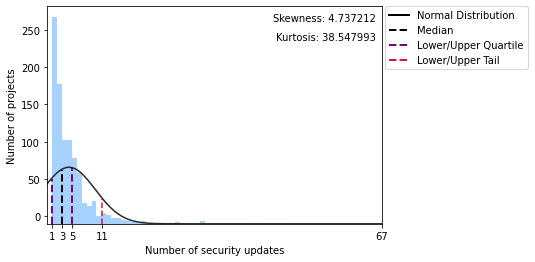

In [8]:
from scipy.stats import norm
from matplotlib.lines import Line2D

plt.rcParams["figure.figsize"] = (12,3)
ax = sns.distplot(total, bins = 67, color="dodgerblue", fit=norm, kde=False, norm_hist=True)
ax.text(x=0.983, y=0.97, transform=ax.transAxes, s="Skewness: %f" % stats.skew(total),
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='black')
ax.text(x=0.983, y=0.88, transform=ax.transAxes, s="Kurtosis: %f" % stats.kurtosis(total, fisher=False),
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='black')
ax.set_xlim([0,67])
ax.set_yticks([0.01, 0.06, 0.11, 0.16, 0.21, 0.26])
ax.set_yticklabels([0, 50, 100, 150, 200, 250])
quantiles = stats.mstats.mquantiles(total)
ax.set_ylabel('Number of projects')
ax.set_xlabel('Number of security updates')
ax.vlines(quantiles[1], 0, ax.lines[0].get_ydata()[int(quantiles[1])+12], color='black', ls='--',linewidth=2.0)
ax.vlines(quantiles[0], 0, ax.lines[0].get_ydata()[int(quantiles[0])+9], color='purple', ls='--',linewidth=2.0)
ax.vlines(quantiles[2], 0, ax.lines[0].get_ydata()[int(quantiles[2])+17], color='purple', ls='--',linewidth=2.0)
ax.vlines(quantiles[2] + 1.5*(quantiles[2]-quantiles[0]), 0, 0.033, color='crimson', ls='--')
ax.set_xticks([quantiles[0], quantiles[1], quantiles[2], quantiles[2] + 1.5*(quantiles[2]-quantiles[0]), max(total)])
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', ls='--', lw=2),
                Line2D([0], [0], color='purple', ls='--', lw=2),
                Line2D([0], [0], color='crimson', ls='--', lw=2)]
lgd = ax.legend(custom_lines, ['Normal Distribution', 'Median', 'Lower/Upper Quartile', 'Lower/Upper Tail'],
                bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.savefig('RQ1-distribution.png', dpi=600, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [9]:
breaks, bins, densities = compute_bins2(total, ratio, [2, 4, 10, 67])
plt.rcParams["figure.figsize"] = (20,5)
number_of_prs = []
merge_rates = []
for i, value in enumerate(breaks):
    if i == 0:
        for j in bins[i]:
            number_of_prs.append('[1,' + str(int(value)) + ']')
            merge_rates.append(j)
    else:
        if value - breaks[i-1] > 1:
            for j in bins[i]:
                number_of_prs.append('[' + str(int(breaks[i-1]) + 1) + ',' + str(int(value)) + ']')
                merge_rates.append(j)
        else:
            for j in bins[i]:
                number_of_prs.append(str(int(value)))
                merge_rates.append(j)
df = pd.DataFrame({'#_security_updates': number_of_prs, 'merge_ratio': merge_rates})
df.head()

,#_security_updates,merge_ratio
0,"[1,2]",0.5
1,"[1,2]",0.0
2,"[1,2]",0.0
3,"[1,2]",0.0
4,"[1,2]",0.0


In [11]:
df2 = df.copy()
df2['merge_ratio'] = df2['merge_ratio']*100
groupedstats= df.groupby('#_security_updates').describe().reset_index().round(2)
groupedstats

#_security_updates merge_ratio                                        
                           count  mean   std  min   25%   50%   75%  max
0              [1,2]       441.0  0.49  0.47  0.0  0.00  0.50  1.00  1.0
1            [11,67]        72.0  0.61  0.38  0.0  0.26  0.78  0.94  1.0
2              [3,4]       213.0  0.59  0.43  0.0  0.00  0.75  1.00  1.0
3             [5,10]       236.0  0.57  0.42  0.0  0.00  0.80  1.00  1.0

In [15]:
#Total statistics
df2['merge_ratio'].describe().reset_index().round(2)

,index,merge_ratio
0,count,962.00
1,mean,54.31
2,std,44.27
3,min,0.00
4,25%,0.00
5,50%,66.67
6,75%,100.00
7,max,100.00


## Statistical Analysis

In [12]:
from scipy.stats import mannwhitneyu

df = df.rename(index=str,columns={'#_security_updates':'group'})

pvalues = pd.DataFrame()

categories = df.group.unique()

for i in range(0,len(categories)):
    for j in range(i,len(categories)):
        if i==j:
            continue
        
        group1 = categories[i]
        group2 = categories[j]
        stat, p = mannwhitneyu(df[df['group']==group1].merge_ratio.values.tolist(), 
                               df[df['group']==group2].merge_ratio.values.tolist())
        
        pvalues = pvalues.append({
            'group1':group1,
            'group2':group2,
            'pvalue':p
        },ignore_index=True)

pvalues

/tmp/ipykernel_842800/307167850.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
/tmp/ipykernel_842800/307167850.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
/tmp/ipykernel_842800/307167850.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
/tmp/ipykernel_842800/307167850.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
/tmp/ipykernel_842800/307167850.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.appe

,group1,group2,pvalue
0,"[1,2]","[3,4]",0.025250
1,"[1,2]","[5,10]",0.100049
2,"[1,2]","[11,67]",0.328718
3,"[3,4]","[5,10]",0.620962
4,"[3,4]","[11,67]",0.544996
5,"[5,10]","[11,67]",0.975924


In [13]:
#Bonferroni correction for multiple comparisons
import statsmodels.stats.multitest as smt

bonfresults = smt.multipletests(
            pvalues.pvalue.values.tolist(),
            alpha=0.05,
            method='bonferroni')

pvalues['corrected_pvalue'] = bonfresults[1]

newthres = bonfresults[3]

pvalues['rejectH0'] = pvalues.apply(lambda x: True if x['corrected_pvalue']<newthres else False , axis=1)
pvalues

,group1,group2,pvalue,corrected_pvalue,rejectH0
0,"[1,2]","[3,4]",0.025250,0.151503,False
1,"[1,2]","[5,10]",0.100049,0.600295,False
2,"[1,2]","[11,67]",0.328718,1.000000,False
3,"[3,4]","[5,10]",0.620962,1.000000,False
4,"[3,4]","[11,67]",0.544996,1.000000,False
5,"[5,10]","[11,67]",0.975924,1.000000,False
